In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fake_news_dataset import FakeNewsDataSet
from fake_news_graph_model import FakeNewsGraphModel
from fake_news_mlp_model import FakeNewsMLPModel
from utils.undirected_transformer import UndirectedTransformer
from utils.evaulator import evaluate

In [2]:
@torch.no_grad()
def compute_test(model, loader, device='cpu', multi_gpu=False, verbose=False):
    model.eval()
    loss_test = 0.0
    out_log = []

    for data in loader:
        if not multi_gpu:
            data = data.to(device)

        out = model(data)
        if multi_gpu:
            y = torch.cat([d.y.unsqueeze(0) for d in data]).squeeze().to(out.device)
        else:
            y = data.y

        if verbose:
            print(F.softmax(out, dim=1).cpu().numpy())

        out_log.append([F.softmax(out, dim=1), y])
        loss_test += F.nll_loss(out, y).item()

    evaluation_metrics = evaluate(out_log, loader)
    return evaluation_metrics, loss_test

In [3]:
def run_experiment(dataset_name, feature_type, base_type, model_type=None, 
                   seed=777, epochs=30, batch_size=128, lr=0.01, wd=0.01, hidden_size=128, dropout=0.0, device='cpu'):
    """
    Runs a single training/validation/testing experiment with given parameters.
    Returns the final test metrics.
    """
    # Set seeds
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load dataset
    dataset = FakeNewsDataSet(
        root='data',
        feature=feature_type,
        empty=False,
        name=dataset_name,
        transform=UndirectedTransformer()
    )
    num_classes = dataset.num_classes
    num_features = dataset.num_features

    # Split dataset
    num_training = int(len(dataset) * 0.2)
    num_val = int(len(dataset) * 0.1)
    num_test = len(dataset) - (num_training + num_val)
    training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])

    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Select model
    if base_type.lower() == 'graph':
        if model_type is None:
            raise ValueError("model_type must be specified for GraphModel base.")
        model = FakeNewsGraphModel(
            num_features=num_features,
            nhid=hidden_size,
            num_classes=num_classes,
            dropout_ratio=dropout,
            model_type=model_type,
            concat=(feature_type=='bert')  # As before, we can choose to concat if using BERT
        )
    elif base_type.lower() == 'mlp':
        model = FakeNewsMLPModel(
            num_features=num_features,
            nhid=hidden_size,
            num_classes=num_classes,
            dropout_ratio=dropout,
            pool_type='mean'  # or 'max'
        )
    else:
        raise ValueError("Invalid base_type. Choose 'graph' or 'mlp'.")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_loss = float('inf')

    # Training
    for epoch in range(epochs):
        model.train()
        loss_train = 0.0
        out_log = []

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            out_log.append([F.softmax(out, dim=1), data.y])

        acc_train, _, _, _, recall_train, auc_train, _ = evaluate(out_log, train_loader)
        [acc_val, _, _, _, recall_val, auc_val, _], loss_val = compute_test(model, val_loader, device=device)

        # You could implement early stopping if desired
        # if loss_val < best_val_loss:
        #     best_val_loss = loss_val
        #     best_model_state = copy.deepcopy(model.state_dict())

    # Testing
    [acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = compute_test(model, test_loader, device=device)

    return {
        'dataset': dataset_name,
        'feature': feature_type,
        'base': base_type,
        'model': model_type if model_type else 'mlp',
        'acc': acc,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'ap': ap
    }

In [6]:
configurations = [
    # politifact
    {'dataset': 'politifact', 'model_type': 'gcn', 'feature_type': 'bert', 'base_type': 'graph'},
    {'dataset': 'politifact', 'model_type': 'gat', 'feature_type': 'bert', 'base_type': 'graph'},
    {'dataset': 'politifact', 'model_type': 'sage', 'feature_type': 'bert', 'base_type': 'graph'},
    {'dataset': 'politifact', 'feature_type': 'bert', 'base_type': 'mlp'},  # MLP no model_type

    # gossipcop
    {'dataset': 'gossipcop', 'model_type': 'gcn', 'feature_type': 'bert', 'base_type': 'graph'},
    {'dataset': 'gossipcop', 'model_type': 'gat', 'feature_type': 'bert', 'base_type': 'graph'},
    {'dataset': 'gossipcop', 'model_type': 'sage', 'feature_type': 'bert', 'base_type': 'graph'},
    {'dataset': 'gossipcop', 'feature_type': 'bert', 'base_type': 'mlp'}  # MLP no model_type
]

In [7]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
EPOCHS = 30

results = []
for cfg in configurations:
    print(f"Running: dataset={cfg['dataset']}, feature={cfg['feature_type']}, base={cfg['base_type']}, model={cfg.get('model_type', 'mlp')}")
    res = run_experiment(
        dataset_name=cfg['dataset'],
        feature_type=cfg['feature_type'],
        base_type=cfg['base_type'],
        model_type=cfg.get('model_type', None),
        device=DEVICE,
        epochs=EPOCHS
    )
    results.append(res)

Running: dataset=politifact, feature=bert, base=graph, model=gcn


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=politifact, feature=bert, base=graph, model=gat


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=politifact, feature=bert, base=graph, model=sage


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=politifact, feature=bert, base=mlp, model=mlp


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=gossipcop, feature=bert, base=graph, model=gcn


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=gossipcop, feature=bert, base=graph, model=gat


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=gossipcop, feature=bert, base=graph, model=sage


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

Running: dataset=gossipcop, feature=bert, base=mlp, model=mlp


/Users/umernaeem/Repos/SeniorProject/fake_news_dataset.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/Use

In [8]:
df = pd.DataFrame(results)
df

,dataset,feature,base,model,acc,f1_macro,f1_micro,precision,recall,auc,ap
0,politifact,bert,graph,gcn,0.787330,0.784000,0.787330,0.891232,0.662462,0.893559,0.891566
1,politifact,bert,graph,gat,0.837104,0.836535,0.837104,0.859048,0.813638,0.885120,0.889080
2,politifact,bert,graph,sage,0.828054,0.827454,0.828054,0.856405,0.796045,0.890118,0.886694
3,politifact,bert,mlp,mlp,0.488688,0.327963,0.488688,0.000000,0.000000,0.814405,0.794476
4,gossipcop,bert,graph,gcn,0.934658,0.934339,0.934658,0.936130,0.933162,0.974749,0.974218
5,gossipcop,bert,graph,gat,0.953476,0.953203,0.953476,0.926855,0.985336,0.992642,0.993032
6,gossipcop,bert,graph,sage,0.952431,0.952131,0.952431,0.927797,0.982158,0.989233,0.989168
7,gossipcop,bert,mlp,mlp,0.884475,0.882735,0.884475,0.822958,0.981140,0.968530,0.964755


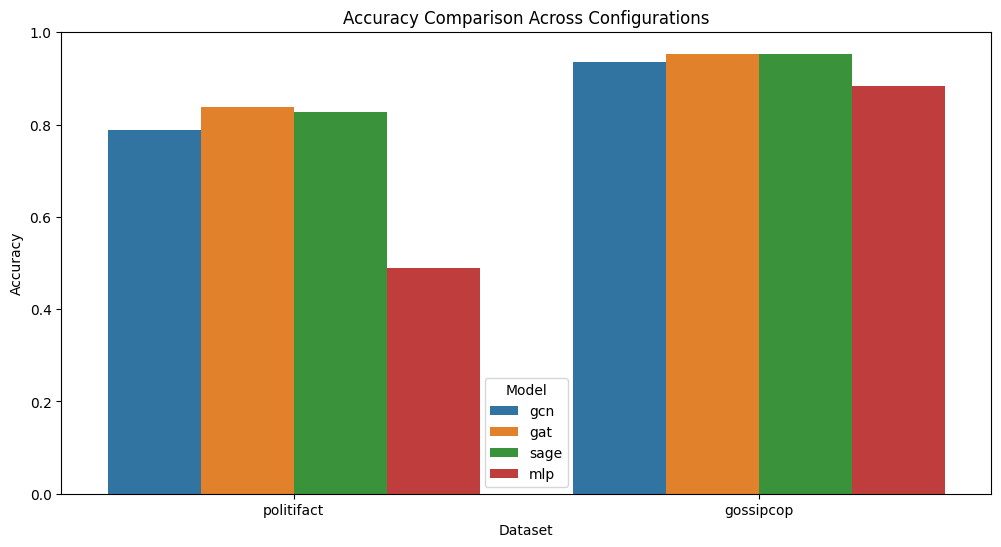

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x='dataset', y='acc', hue='model')
plt.title('Accuracy Comparison Across Configurations')
plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.legend(title='Model')
plt.show()

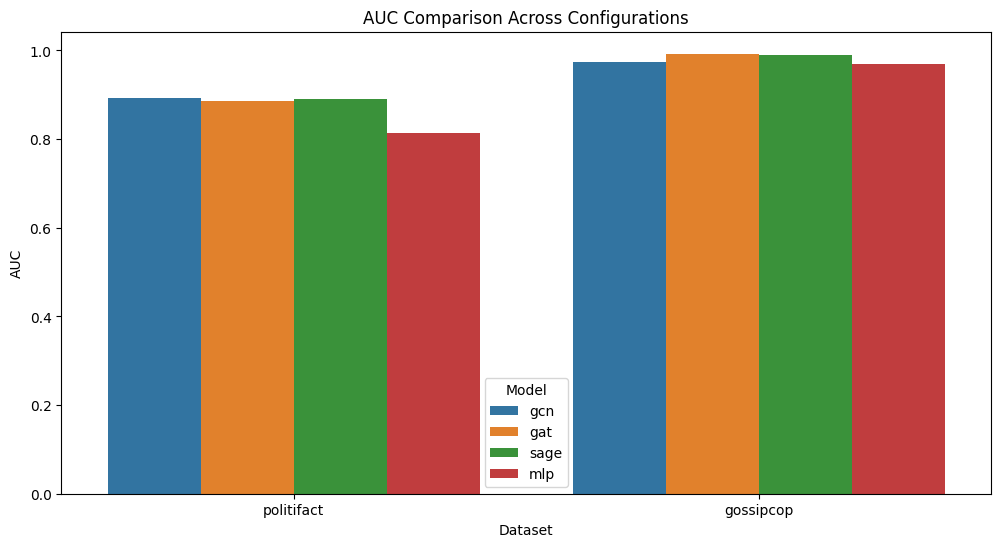

In [10]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x='dataset', y='auc', hue='model')
plt.title('AUC Comparison Across Configurations')
plt.ylabel('AUC')
plt.xlabel('Dataset')
plt.legend(title='Model')
plt.show()

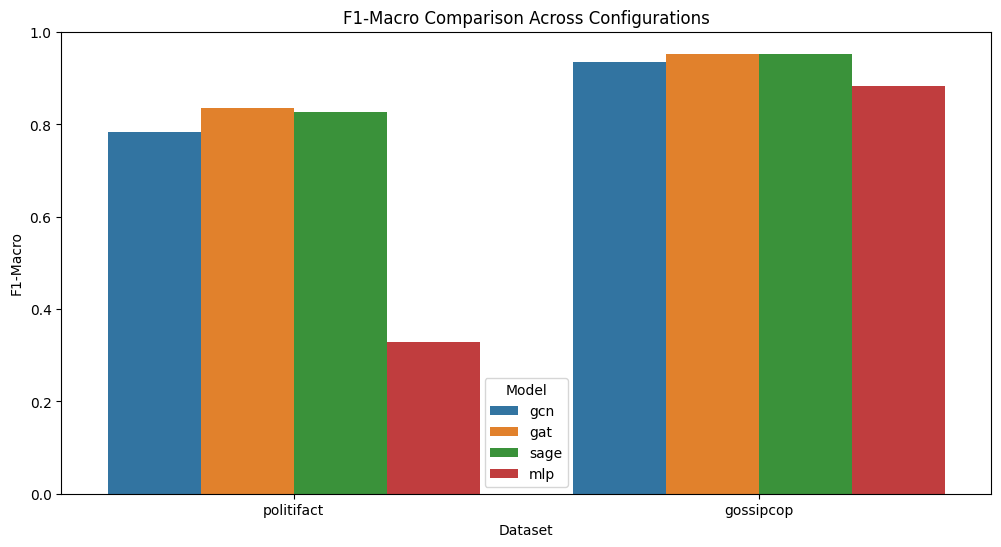

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x='dataset', y='f1_macro', hue='model')
plt.title('F1-Macro Comparison Across Configurations')
plt.ylabel('F1-Macro')
plt.xlabel('Dataset')
plt.legend(title='Model')
plt.show()